In [1]:
cd /home/schlecker/repos/planeteScripts

/home/schlecker/repos/planeteScripts


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

import output
import plots
import stats
import utils

%load_ext autoreload
%autoreload 2

# default output folder
outputs = '/home/schlecker/phd/planete/outputs/pop06_MstarGrid/'
# outputs = '/media/martin/Daten/phd/planete/outputs/pop06_MstarGrid/'

pd.set_option('display.max_columns', 500)

## Basic statistics

### initiate the 'master' population with subpopulations for each stellar mass
All ref_red data will be in one multiindex-dataframe

In [3]:
filenames = ['ref_red5e9_0.3Msol.dat', 'ref_red5e9_0.5Msol.dat', 
             'ref_red5e9_0.7Msol.dat', 'ref_red5e9_1.0Msol.dat'] 
fileList = [outputs + f for f in filenames]
Mgrid = output.Population(fileList, name='Mgrid')

how about a summary plot?

In [ ]:
def plot_typeStats(populations):
    """
    
    """
    if isinstance(populations, list):
        stats = {p.name : p.get_typeStats() for p in populations}
        fig, ax = plt.subplots()
        stellarMasses = [0.3, 0.5, 0.7, 1.0]
        for M, Mstar in enumerate(stats.keys()):
            for planetType in stats[Mstar]:
                plt.errorbar(stellarMasses[M], stats[Mstar][planetType]['meanMetallicity'], stats[Mstar][planetType]['stdMetallicity'],
                             capsize=40., fmt='o', label=planetType)
        plt.legend()

## disk lifetime analysis

In [ ]:
tDiskFiles = [outputs + s for s in ['ref_redtdisk_0.3Msol.dat','ref_redtdisk_0.5Msol.dat', 'ref_redtdisk_0.7Msol.dat', 'ref_redtdisk_1.0Msol.dat']]

In [ ]:
Mgrid = output.Population()
Mgrid.read_tDiskData(tDiskFiles)

compute disk fractions and store them separately for each Mstar

In [ ]:
diskFractions = {Mstar : utils.get_diskFractions(tDiskData, Ntimes=50) for Mstar, tDiskData in Mgrid.tDiskData.groupby(level=0)}

fit exponential function to disk fractions

To parametrize the fraction of remaining disks, we apply a simple exponential fit of the form f(t) = A*exp(-t/tau) + C. There is a clear trend of increasing disk lifetimes with increasing stellar mass. 

In [ ]:
# import ipdb; ipdb.set_trace()

In [ ]:
ax, diskFractions, tau, std_tau = plots.plot_diskFractions(diskFractions)

what is the trend in 'tau'?

In [ ]:
Mstar = [float(key[:-4]) for key in diskFractions.keys()]
# tau = [m[2][1] for m in diskFractions.values()]

In [ ]:
ax = plots.plot_diskLifetimeComparison(Mstar, tau, std_tau, nSigma=1)

In this plot we see that the scaling of tau is positive and linear in host star mass. This contradicts the findings of Ribas et al. (2015), who not only find a negative trend with some significance, but also report typical infrared excess decay times of ~(2-6)Myr, which is consistently lower than our values

### Mstar-dependent histograms

In [5]:
def plot_multiHistogram(dataFrame, columnNames, ax=None, **kwargs):
    """ Plot multiple histograms from a dataFrame into the same axis.
    
    Parameters
    ----------
    dataFrame : pandas DataFrame
        dataFrame containing column(s) stated in 'columnNames'
    columnNames : str or list
        name(s) of the column(s) to plot.
        
    Returns
    -------
    ax : matplotlib axis
        axis with the plot
    """
    if ax == None:
        fig, ax = plt.subplots()
    
    if not kwargs:
        mplKwargs = {'alpha' : 0.6,
                     'histtype' : 'stepfilled',
                     'edgecolor' : 'black',
                     'linewidth' : 1.2,
                     'bins' : 50}
    else:
        mplKwargs = {}
    
    if isinstance(columnNames, list):
        # plot different columns of the same dataFrame        
        for name in columnNames:
            ax.hist(dataFrame[name], label=name, **mplKwargs, **kwargs)
    
    elif isinstance(columnNames, str):
        # assume that dataFrame is multiindexed, iterate over outermost level
        for label, subpopulation in dataFrame.groupby(level=0):
           ax.hist(subpopulation[columnNames], label=label, **mplKwargs, **kwargs)
    ax.legend()
    return ax


# test
# group = Mgrid.tDiskData.groupby(level=0)
# tDiskData03 = group.get_group('0.3Msol')
# plot_multiHistogram(tDiskData03, ['m', 'r', 't'], bins=50)

# more tests
# plot_multiHistogram(Mgrid.tDiskData, 'm', bins=50)

## create occurrence maps

In [ ]:
plots.plot_occurrence?

#### plot all maps into one figure

In [ ]:
# fix all ranges for better comparison of subpopulations
smaRange = [1e-2, 50.] 
radRange = [2e-1, 400.]
colRange = [0., 10.]

fig, axes = plt.subplots(2,2, sharex=True, sharey=True)

for (label, population), ax in zip(Mgrid.tDiskData.groupby(level=0), axes.reshape(-1)):

    h, x, y, ax, im = plots.plot_occurrence(population, xAxis='a', logColormap=True, xRange=smaRange,
                                        yRange=radRange, zRange=colRange, showColorbar=False, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    t = ax.text(.07, .85, label[:-4] + ' M$_\odot$', color='white', transform=ax.transAxes)

    
fig.text(0.45, 0.01, 'Semimajor Axis [au]', ha='center')
fig.text(0.01, 0.55, 'Planet Size [$\mathrm{R_{Earth}}$]', va='center', rotation='vertical')
  
cbar_ax = fig.add_axes([0.84, 0.13, 0.04, 0.84])
cbarlabel = r"Planets per 100 Stars per $a-R_P$ interval"
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(cbarlabel, labelpad=5.)

plt.subplots_adjust(left=.11, bottom=.13, right=.79, top=.97, wspace=.08, hspace=.08)

## Joint simlist - population analysis

In [ ]:
# read simulation lists into population
simlistFiles = [outputs + s for s in ['simulation_list_0.3Msol.dat', 'simulation_list_0.5Msol.dat', 'simulation_list_0.7Msol.dat', 'simulation_list_1.0Msol.dat']]
Mgrid.read_simlist(simlistFiles)

### check scaling of initial disk mass

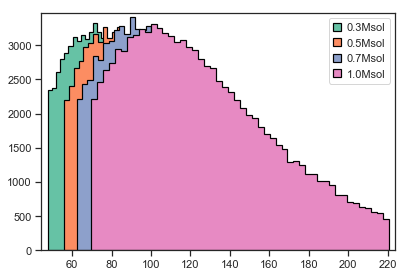

In [7]:
ax = plot_multiHistogram(Mgrid.simlist, 'sigma0', histtype='stepfilled',
                    edgecolor='black', linewidth=1.2, bins=50)

In [8]:
Mgrid.simlist.groupby(level=0).sigma0.describe()

,count,mean,std,min,25%,50%,75%,max
0.3Msol,100000.0,86.666017,25.276031,47.793820,66.209441,82.780822,103.756507,151.34799
0.5Msol,100000.0,101.635550,29.680076,56.065275,77.518714,96.877105,121.758120,177.55120
0.7Msol,100000.0,112.761427,32.816785,62.282532,86.256620,107.381430,134.934715,197.22960
1.0Msol,100000.0,126.125117,36.724669,69.624182,96.416485,120.384990,150.995765,220.49399


translate to disk mass to check its distribution (we have to work with a smaller sample because 400'000 entries are a bit heavy)

In [101]:
Mgrid.simlist['mDisk'] = Mgrid.simlist['sigma0']

simlistSample= Mgrid.simlist.sample(10000)

In [102]:
simlistSample['mDisk'] = simlistSample['mDisk'].apply(utils.get_M0, args=(simlistSample['a_out'], 0.9))

In [103]:
simlistSample.groupby(level=0).mDisk.describe()

,count,mean,std,min,25%,50%,75%,max
0.3Msol,2551.0,0.016767,0.004909,0.009203,0.012811,0.015870,0.020178,0.029114
0.5Msol,2446.0,0.019306,0.005683,0.010794,0.014705,0.018341,0.023296,0.034158
0.7Msol,2423.0,0.021892,0.006335,0.011996,0.016892,0.020824,0.026258,0.037877
1.0Msol,2580.0,0.024364,0.007136,0.013397,0.018567,0.023266,0.029310,0.042325


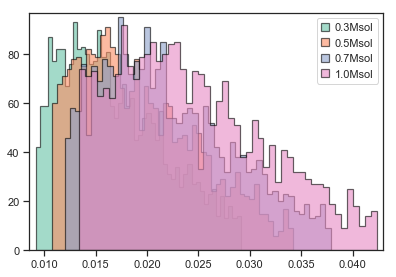

In [104]:
plot_multiHistogram(simlistSample, 'mDisk')#, histtype='stepfilled', edgecolor='black', linewidth=1.2, bins=50)

In [ ]:
simlistSample.groupby(level=0).groups.keys()

does the linear scaling function work?

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0,10)
y = utils.linearScale(0,10,2,10,x)
ax.plot(x, y)
plt.show()

looks good. 

The disk masses / Sigma_0 doesn't seem to scale linearly with Mstar as planned. let's try to reproduce what happens in make_list to find the bug

In [11]:
Mstar = [0.3, 0.5, 0.7, 1.0]

# distribution from Andrews et al. (2010)
MdiskDist = 10**(-1.66 + 0.56*np.random.normal(size=10000))

# scale disk masses linearly with Mstar
disk_mass = [MdiskDist*M**1.0 for M in Mstar]

In [133]:
df = pd.DataFrame.from_items(zip([str(M) for M in Mstar], disk_mass))
df.describe()

,0.3,0.5,0.7,1.0
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.014361,0.023935,0.033508,0.047869
std,0.026670,0.044449,0.062229,0.088898
min,0.000042,0.000070,0.000098,0.000139
25%,0.002717,0.004528,0.006339,0.009056
50%,0.006487,0.010811,0.015135,0.021622
75%,0.015296,0.025493,0.035690,0.050986
max,0.577785,0.962975,1.348165,1.925949


In [10]:
plot_multiHistogram(df, [str(M) for M in Mstar])

NameError: name 'df' is not defined

We check the difference it makes when we apply the min/max cuts for mdisk

In [150]:
mdisks_nocut = '/home/schlecker/phd/planete/MstarGrid/mdisks_no_cut.csv'
mdisks_nocut0p5 = '/home/schlecker/phd/planete/MstarGrid/mdisks_no_cut_0p5.csv'
mdisksDebug = pd.read_csv(mdisks_nocut)
mdisksDebug0p5 = pd.read_csv(mdisks_nocut0p5)

In [165]:
ax = mdisksDebug0p5.hist(bins=50, alpha=.3)
mdisksDebug.hist(bins=50, ax=ax, alpha=.3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1904c689e8>], dtype=object)

-----------------------------

#### look at the ref_red1e5, which include disk masses directly from make_list

In [18]:
refred3e5Files = ['ref_red3e5_' + str(M) + 'Msol.dat' for M in Mstar]
refred3e5Files = [outputs + s for s in refred3e5Files]
MstarGrid3e5 = output.Population(refred3e5Files)

In [28]:
plots.plot_multiHistogram(MstarGrid3e5.data, 'mdiskg')

In [31]:
MstarGrid3e5.data.groupby(level=0).mdiskg.describe()

,count,mean,std,min,25%,50%,75%,max
0.3Msol,9988.0,0.008391,0.008878,0.000551,0.002114,0.004937,0.011421,0.041915
0.5Msol,9999.0,0.015109,0.015647,0.001136,0.003976,0.008934,0.020608,0.073322
0.7Msol,9993.0,0.021449,0.021921,0.001743,0.005901,0.012795,0.029140,0.104426
1.0Msol,9969.0,0.031076,0.030789,0.002721,0.009084,0.019530,0.042031,0.151233


This scales as expected.

### check relation between Tdisk, Mwind, Sigma0

In [ ]:
from scipy.optimize import curve_fit

def tDiskRel(Mwind, Sigma0, a, b, c):
    return a*(1e-7/Mwind)**b*(Sigma0/100)**c

params, covariance = curve_fit(tDiskRel, [simlistSample['windM'], simlistSample['sigma0']])

In [ ]:
plt.plot(simlistSample['windM'], tDiskRel(simlistSample['windM'], simlistSample['sigma0'], *params))

...stopped for now

### Distributions for giant planets
Since we are working with single-planet-populations, let's focus on giants (which should be little affected by planet-planet interactions) 

In [32]:
# define minimum mass for giant planet
mGiant = 300.

giants = Mgrid.data[(Mgrid.data['m'] > mGiant) & (Mgrid.data[64] == 0)]
len(giants)

2704

In [36]:
plot_multiHistogram(giants, 'a')